In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from tqdm import tqdm

from torchdyn.core import NeuralODE

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)

/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/lightning_utilities/core/imports.py:93: UserWarning: Unbuilt egg for MIOFlow [unknown version] (/home/mila/a/alexander.tong/MIOFlow)
  pkg_resources.require(self.requirement)


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 3

trainset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))
                   ]))

train_loader = torch.utils.data.DataLoader(trainset,
    batch_size=batch_size, shuffle=True, drop_last=True)

In [3]:
#################################
#            OT-CFM
#################################

sigma = 0.0
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)
optimizer = torch.optim.Adam(model.parameters())
#FM = ConditionalFlowMatcher(sigma=sigma)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(
    model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
)

468it [01:03,  7.38it/s]


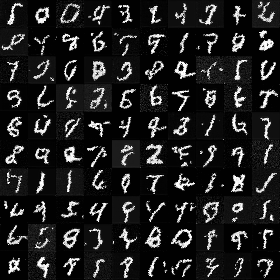

468it [00:58,  8.06it/s]


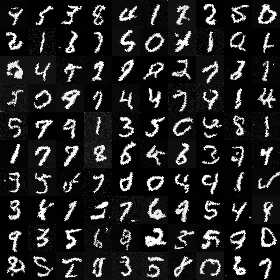

468it [00:57,  8.20it/s]


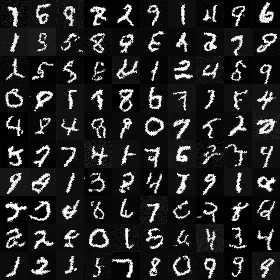

In [4]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28).to(device),
            t_span=torch.linspace(0, 1, 2).to(device),
        )
    grid = make_grid(traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10)
    img = ToPILImage()(grid)
    img.show()